In [5]:
###IMPORT MODULES
import numpy as np 
from tools.component_tools import Component
from tools.component_tools import Fluid
from tools.component_tools import Membrane
from tools.component_tools import GLC_Gas
from tools.component_tools import GLC 
from tools.materials import Flibe 
import tools.correlations as corr
import tools.materials as materials
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy.optimize import fsolve
import matplotlib.lines as mlines

In [6]:
##Define sweep vectors
d_hyd_v=np.logspace(-3,np.log10(5E-2),100)
T_vec=np.linspace(800,1000,30)
U0_vec=np.linspace(1,5,30)
str_v_vec=['T','U0','Solubility','c_in',"D","thick","K_S","k_d","k_r"]
c_in_vec=np.logspace(-5,-1,30)
D_vec=np.logspace(-10,-8,30)
thick_vec=np.logspace(-3,-1,30)
K_S_vec=np.logspace(-4,-2,30)
k_d_vec=np.logspace(2,6,30)
k_r_vec=np.logspace(2,6,30)
solubility_vec=np.logspace(-5,-2,30)
v_vec=np.array([T_vec, U0_vec, solubility_vec, c_in_vec, D_vec, thick_vec, K_S_vec])
eff_v_vec=np.array([])
fluid_v_bool=np.array([True , True , True ,False,False,False,False,False,False])
solid_v_bool=np.array([False, False, False,False,True ,True ,True ,True ,True ])


In [7]:
#Define other HX constraints

T_hot_prim=900
T_hot_sec=800
T_cold_prim=838
T_cold_sec=581
T_sec_ave=(T_hot_sec+T_cold_sec)/2
m_in_sec=3025
m_in_prim=4950
rho_sec=2263.628-0.636*T_sec_ave
mu_sec=0.075439-2.77E-4*T_sec_ave+3.49E-7*T_sec_ave**2-1.474E-10*T_sec_ave**3
k_sec=0.45
cp_sec=1396.044+0.172*(T_sec_ave)
N_HX=3


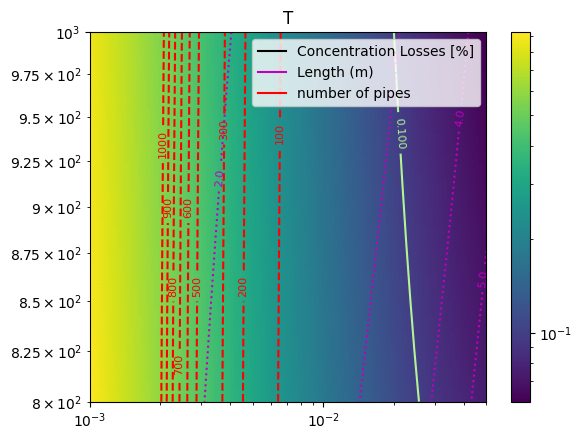

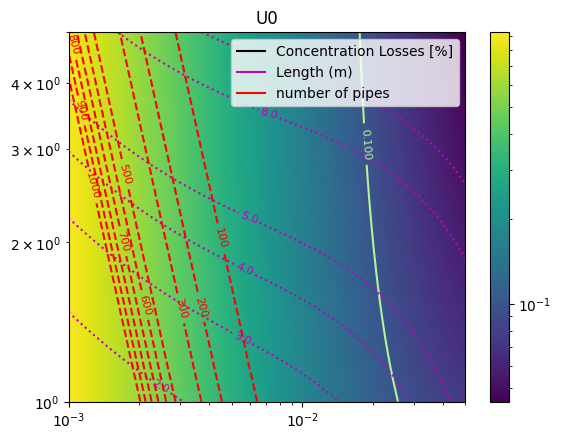

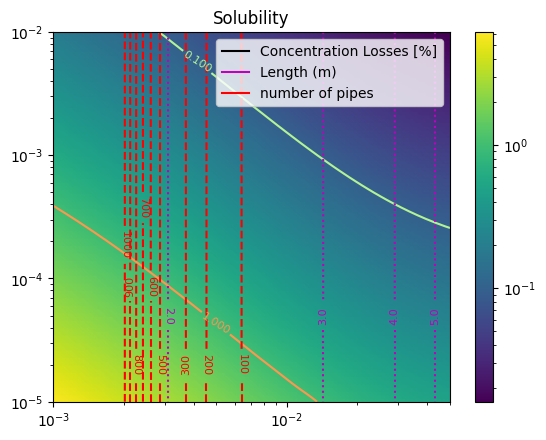

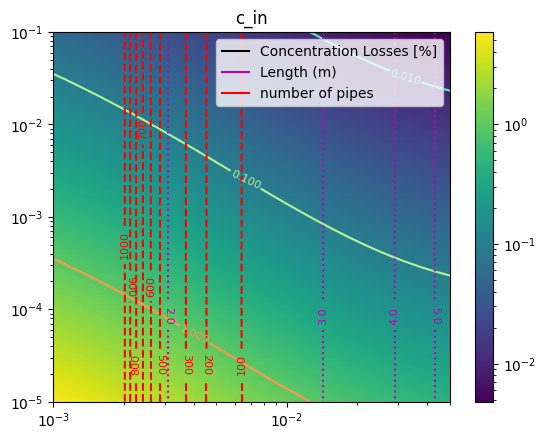

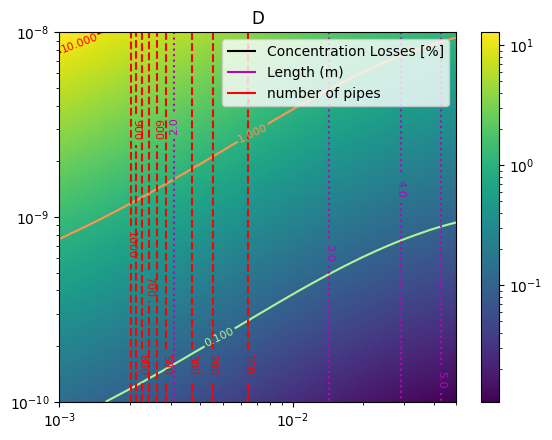

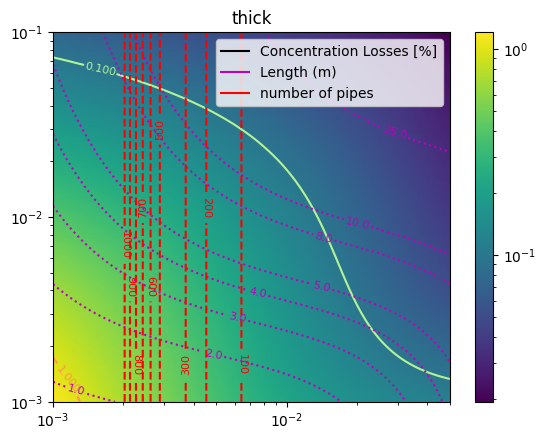

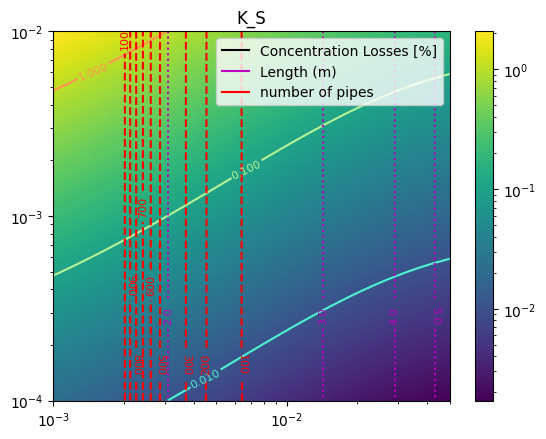

In [8]:

for j,vec in enumerate(v_vec):
        eff_v=np.array([])
        var_str=str_v_vec[j]
        T=800
        res_vec=np.array([])
        d_hyd_v_res=np.array([])
        var_vec=np.array([])
        L_vec=np.array([])
        n_pipes_v=np.array([])
        for var in vec:
                for i,d_hyd in enumerate(d_hyd_v):
                        if str_v_vec[j]=='T':
                                T=var
                                #print(T)
                        c0=4.1E-4
                        mat=materials.Flibe(T)
                        
                        flibe=Fluid(T=T, Solubility=mat.Solubility, MS=True,D=mat.D, d_Hyd=d_hyd ,mu=mat.mu,rho=mat.rho,U0=1, c0=c0,k=mat.k,
                         cp=mat.cp)
                        Steel = Membrane( T=T,
                                D=7E-10,
                                thick=2.1E-3,
                                K_S=4.41E-3,
                                k_d=1E6,
                                k_r=1E6,k=21)
                        PAV = Component(c_in=c0, eff=0.5, fluid=flibe, membrane=Steel)
                        
                        if fluid_v_bool[j]==True:
                                PAV.fluid.update_attribute(var_str,var)
                        elif solid_v_bool[j]==True:
                                PAV.membrane.update_attribute(var_str,var)
                        else:
                                PAV.update_attribute(var_str,var)
                        n_pipes=m_in_prim/(PAV.fluid.cp*PAV.fluid.rho*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                        Q=1E6/n_pipes/N_HX
                        HX=Component(c_in=PAV.outlet_c_comp(), eff=0.08, fluid=flibe)
                        PAV.get_adimensionals()
                        d_h_sec=2.5E-2 # from HX forecasts
                        U_sec=m_in_sec/(rho_sec*d_h_sec**2*np.pi/4)/N_HX
                        Re_sec=corr.Re(rho=rho_sec,u=U_sec,mu=mu_sec,L=d_h_sec)
                        Pr_sec=corr.Pr(c_p=cp_sec,mu=mu_sec,k=k_sec)
                        h_coeff_sec=corr.get_h_from_Nu(corr.Nu_DittusBoelter(Re_sec, Pr_sec), k_sec,d_h_sec)
                        U_sec=1/h_coeff_sec
                        U = PAV.get_global_HX_coeff(U_sec)
                        L= corr.get_length_HX(corr.get_deltaTML(T_hot_prim, T_cold_prim, T_cold_sec, T_hot_sec), PAV.fluid.d_Hyd, PAV.U, Q)
                        PAV.get_efficiency(L,plotvar=False)
                        out_flux=(PAV.c_in*(1-PAV.eff)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                        eff_v=np.append(eff_v, PAV.eff)
                        d_hyd_v_res=np.append(d_hyd_v_res, d_hyd)
                        var_vec=np.append(var_vec, var)
                        res_vec=np.append(res_vec, PAV.eff)
                        L_vec=np.append(L_vec, L)
                        n_pipes_v=np.append(n_pipes_v, n_pipes)
                eff_v_vec=np.append(eff_v_vec, eff_v)
        plt.figure(j)
        plt.title(str_v_vec[j])
        
        x = np.logspace(np.log10(min(d_hyd_v_res[:])), np.log10(max(d_hyd_v_res[:])), num=100)
        y = np.logspace(np.log10(min(var_vec[:])), np.log10(max(var_vec[:])), num=100)
        X, Y = np.meshgrid(x, y)
        plt.yscale('log')
        plt.xscale('log')
        Z = griddata((d_hyd_v_res, var_vec), (1-res_vec)*100, (X, Y), method='cubic')
        #plt.contour(X, Y, Z, levels=[0.95,0.99,0.9999], colors=['k','r','b'])
        contour1=plt.contour(X, Y, Z, levels=[1E-4,1E-3,1E-2,1E-1,1,10],norm=LogNorm(), cmap='rainbow')
        plt.clabel(contour1, inline=True, fontsize=8)
        scatter=plt.scatter(X,Y, c=Z ,norm=colors.LogNorm()) #,norm=colors.LogNorm()
        ZL=griddata((d_hyd_v_res, var_vec), L_vec, (X, Y), method='cubic')
        Zn_pipes=griddata((d_hyd_v_res, var_vec), n_pipes_v, (X, Y), method='cubic')
        contour2=plt.contour(X, Y, ZL, levels=[0.5,1,2,3,4,5,8,10,25,],colors=['m'],linestyles='dotted')
        plt.clabel(contour2, inline=True, fontsize=8)
        contour3=plt.contour(X, Y, Zn_pipes, levels=[100,200,300,500,600,700,800,900,1000],colors=['r'],linestyles='dashed')
        plt.clabel(contour3, inline=True, fontsize=8)
        #plt.colorbar(contour1)  # Show color scale for contour1
        plt.colorbar(scatter)  # Show color scale for scatter
        line1 = mlines.Line2D([], [], color='k', markersize=15, label='Concentration Losses [%]')
        line2 = mlines.Line2D([], [], color='m', markersize=15, label='Length (m)')
        line3 = mlines.Line2D([], [], color='r', markersize=15, label='number of pipes')
        plt.legend(handles=[ line1,line2, line3], loc='upper right')

        # plt.colorbar(contour2)  # Show color scale for contour2
        # plt.colorbar(contour3) # Show color scale
        plt.show()

Jupyter notebook to test and run features of components in a FPP